In [20]:
%load_ext jupyternotify

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import timeit
import joblib

import main

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
# from scipy.stats import *

pd.set_option('display.max_columns', None)

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [21]:
# pd.set_option('display.max_colwidth', None)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [22]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
data_df_1522 = pd.read_csv('data/PitchDataCleanedLean_15-22.csv', index_col=[0])

In [25]:
data_train_df = data_df_1522[data_df_1522['game_year'].isin([2015, 2016, 2017, 2018])].copy()

In [26]:
# data_df_1518 = pd.read_csv('data/PitchDataCleanedLean_15-18.csv', index_col=[0])

In [27]:
data_test_df = data_df_1522[data_df_1522['game_year']==2019].copy()

In [9]:
# data_df_19 = pd.read_csv('data/PitchDataCleanedLean_19.csv', index_col=[0])

In [10]:
# B_COUNT_LIST = [0, 1, 2, 3]
# S_COUNT_LIST = [0, 1, 2]
# EVENT_LIST = ['1B', '2B', '3B', 'HR', 'FO', 'BB', 'K', 'other']
# COUNT_LIST = [(b, s) for s in S_COUNT_LIST for b in B_COUNT_LIST]

# Player filter

In [11]:
pa_batter = data_train_df.groupby(['batter', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_batter['n_count'] = 1
pa_batter = pa_batter.groupby('batter').agg({'n_count':sum}).reset_index()
pa_batter.head()

pa_batter['n_count'].mean()

print(pa_batter[pa_batter['n_count']>=400].shape)

pa_pitcher = data_train_df.groupby(['pitcher', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_pitcher['n_count'] = 1
pa_pitcher = pa_pitcher.groupby(['pitcher']).agg({'n_count':sum}).reset_index().copy()

pa_pitcher['n_count'].mean()

print(pa_pitcher[pa_pitcher['n_count']>=500].shape)

(491, 2)
(487, 2)


## Create player filter

In [12]:
batter_quali_list = pa_batter[pa_batter['n_count']>=400]['batter'].to_list()
len(batter_quali_list)

491

In [13]:
# %store batter_quali_list

In [14]:
pitcher_quali_list = pa_pitcher[pa_pitcher['n_count']>=500]['pitcher'].to_list()
len(pitcher_quali_list)

487

# Markov Chain

In [15]:
# 592450

In [16]:
# Mike Trout T matrix

player_id = 545361

T = main.get_player_T(player_id, is_pitcher=False, data_df=data_train_df)

In [19]:
main.convert_T_df(T)

,"(0, 0)","(1, 0)","(2, 0)","(3, 0)","(0, 1)","(1, 1)","(2, 1)","(3, 1)","(0, 2)","(1, 2)","(2, 2)","(3, 2)",1B,2B,3B,HR,FO,BB,K,other
"(0, 0)",0.00000,0.41626,0.00000,0.00000,0.52655,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01307,0.00531,0.00041,0.00572,0.03023,0.00245,0.00000,0.00000
"(1, 0)",0.00000,0.00000,0.38469,0.00000,0.00000,0.49166,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.03140,0.00589,0.00196,0.01079,0.06869,0.00393,0.00000,0.00098
"(2, 0)",0.00000,0.00000,0.00000,0.39031,0.00000,0.00000,0.47704,0.00000,0.00000,0.00000,0.00000,0.00000,0.02806,0.00765,0.00000,0.02041,0.06888,0.00765,0.00000,0.00000
"(3, 0)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.49020,0.00000,0.00000,0.00000,0.00000,0.00654,0.00000,0.00000,0.00000,0.02614,0.47712,0.00000,0.00000
"(0, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.47634,0.00000,0.00000,0.37161,0.00000,0.00000,0.00000,0.02793,0.01319,0.00388,0.01396,0.08689,0.00543,0.00000,0.00078
"(1, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.39821,0.00000,0.00000,0.43049,0.00000,0.00000,0.04215,0.00807,0.00090,0.01883,0.09865,0.00269,0.00000,0.00000
"(2, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.31854,0.00000,0.00000,0.46276,0.00000,0.04279,0.02853,0.00000,0.01426,0.12678,0.00634,0.00000,0.00000
"(3, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.43841,0.04710,0.01812,0.00362,0.03261,0.14130,0.31884,0.00000,0.00000
"(0, 2)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.16112,0.58319,0.00000,0.00000,0.02977,0.00350,0.00000,0.01401,0.09107,0.00525,0.11208,0.00000
"(1, 2)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.17125,0.52599,0.00000,0.04077,0.00815,0.00204,0.00917,0.08563,0.00408,0.15291,0.00000


In [17]:
main.convert_T_df(main.sim_steady_state(T))

,"(0, 0)","(1, 0)","(2, 0)","(3, 0)","(0, 1)","(1, 1)","(2, 1)","(3, 1)","(0, 2)","(1, 2)","(2, 2)","(3, 2)",1B,2B,3B,HR,FO,BB,K,other
"(0, 0)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13971,0.04616,0.00735,0.05801,0.36397,0.17606,0.20792,0.00082
"(1, 0)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13545,0.04256,0.00607,0.05677,0.34521,0.25221,0.16075,0.00098
"(2, 0)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09905,0.03944,0.00331,0.05204,0.27908,0.42055,0.10653,0.00000
"(3, 0)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04492,0.01476,0.00256,0.02344,0.14247,0.72440,0.04745,0.00000
"(0, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13342,0.04393,0.00839,0.05443,0.36093,0.13033,0.26780,0.00078
"(1, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13412,0.04373,0.00577,0.05279,0.34404,0.17594,0.24361,0.00000
"(2, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11205,0.05455,0.00485,0.04713,0.32408,0.27285,0.18449,0.00000
"(3, 1)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.07830,0.03012,0.00522,0.04781,0.23731,0.50444,0.09680,0.00000
"(0, 2)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.11196,0.02668,0.00475,0.04122,0.29643,0.11058,0.40838,0.00000
"(1, 2)",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10999,0.03237,0.00683,0.03527,0.27024,0.15006,0.39524,0.00000


# Get all player T

In [ ]:
# T_batters_dict_1518_new = main.get_allplayers_T(batter_quali_list, data_train_df)

# T_pitchers_dict_1518_new = main.get_allplayers_T(pitcher_quali_list, data_train_df, True)

In [ ]:
# joblib.dump(T_batters_dict_1518_new, 'data/T/T_batters_dict_1518_new')
# joblib.dump(T_pitchers_dict_1518_new, 'data/T/T_pitchers_dict_1518_new')

### Dump T dicts

### Load T dicts

In [ ]:
# T_batters_dict_jan18 = joblib.load('data/T/T_batters_dict_jan18')
# T_pitchers_dict_jan18 = joblib.load('data/T/T_pitchers_dict_jan18')

In [12]:
T_batters_dict_1518_new = joblib.load('data/T/T_batters_dict_1518_new')
T_pitchers_dict_1518_new = joblib.load('data/T/T_pitchers_dict_1518_new')

In [ ]:
# # create quali list from T dict keys
# batter_quali_list = list(T_batters_dict_jan18.keys())
# pitcher_quali_list = list(T_pitchers_dict_jan18.keys())

# len(batter_quali_list)

# len(pitcher_quali_list)

# create matchup steady state 

In [ ]:
trout_id = 545361
verlander_id = 434378
p_weight = 0.4

T_batter = T_batters_dict[trout_id]
T_pitcher = T_pitchers_dict[verlander_id]

T_matchUp = (T_pitcher*p_weight + T_batter*(1-p_weight))

P_steady_matchUp = main.sim_steady_state(T_matchUp)

P_steady_matchUp_df = main.convert_T_df(P_steady_matchUp)

P_steady_matchUp_df = P_steady_matchUp_df.iloc[:12][P_steady_matchUp_df.columns[-8:]].copy()

steady_state_matchUp = main.sim_steady_state_matchUp(verlander_id, trout_id, batter_dict=T_batters_dict, pitcher_dict=T_pitchers_dict)
steady_state_matchUp

In [ ]:
emp_matchUp_T = main.get_emp_matchUp_T(verlander_id, trout_id, data_train_df)

emp_steady_state = main.sim_steady_state(emp_matchUp_T)

In [ ]:
steady = main.convert_T_df(emp_steady_state)

In [ ]:
steady

# Test for pitcher weight

In [32]:
pa_df = data_test_df[(data_test_df['pitcher'].isin(pitcher_quali_list)&(data_test_df['batter'].isin(batter_quali_list)))]\
                    .groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter'])\
                    .agg({
    'home_team':'first',
    'stand':'first',
    'p_throws':'first',
    'event_type':'first',
    'des':'first'
}).reset_index()

In [33]:
event_df = pd.get_dummies(pa_df['event_type'])
event_df = event_df[main.EVENT_LIST].copy()

pa_df = pd.concat([pa_df, event_df], axis=1).copy()

event_arr = event_df.values

In [34]:
matchup_pairs_full = list(zip(pa_df['pitcher'], pa_df['batter']))

In [35]:
len(matchup_pairs_full)

83661

In [36]:
# b_score_list = []
# for p_weight in tqdm(np.arange(0, 1.05, 0.05)):
#     P_matchUp_dict = {}
#     for pair in tqdm(matchUp_pairs_list):
#         P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=p_weight, _return_df=False)
#         P_matchUp_dict[pair] = P_steady_matchUp_arr
        
#     P_predicted = np.array([P_matchUp_dict[pair] for pair in all_matchUp_pairs_list])
#     b_score = get_brier_score(P_predicted, event_dummies.values)
#     b_score_list.append(b_score)

# list(zip([w for w in np.arange(0, 1.05, 0.05)], b_score_list))

In [37]:
matchup_sets_df = data_test_df[(data_test_df['pitcher'].isin(pitcher_quali_list)&(data_test_df['batter'].isin(batter_quali_list)))]\
.groupby(['pitcher', 'batter']).agg({'n_count':sum}).reset_index()

In [38]:
matchup_sets_df.shape

(31448, 3)

In [39]:
matchup_pairs_list = list(zip(matchup_sets_df['pitcher'], matchup_sets_df['batter']))

In [40]:
def normalize_P(P_arr):
    devider = P_arr.sum(axis=1)
    devider = np.reshape(devider, [len(devider), 1])
    return P_arr / devider

In [41]:
def test_p_weight(p_weight_list, matchup_test_list, batter_dict, pitcher_dict):
    b_score_list = []
    for p_weight in tqdm(p_weight_list):
        P_matchup_dict = {}
        for pair in tqdm(matchup_pairs_list):
            P_matchup_dict[pair] = main.sim_steady_state_matchUp(pair[0], pair[1], p_weight=p_weight, _return_df=False, batter_dict=batter_dict, pitcher_dict=pitcher_dict)

        P_predicted = np.array([P_matchup_dict[pair] for pair in matchup_test_list])
        # normalize proba to 1
        P_predicted = normalize_P(P_predicted)
        b_score_list.append(main.get_brier_score(P_predicted, event_arr))
    return b_score_list

In [25]:
p_weight_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
b_score_list = test_p_weight(p_weight_list, matchup_pairs_full, T_batters_dict_1518_new, T_pitchers_dict_1518_new)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

In [26]:
list(zip(p_weight_list, b_score_list))

[(0, 0.7050986238475694),
 (0.1, 0.7043698644282578),
 (0.2, 0.7038931313650366),
 (0.3, 0.7036651693156838),
 (0.4, 0.7036837368239015),
 (0.5, 0.7039475929398252),
 (0.6, 0.7044564881417013),
 (0.7, 0.705211159667),
 (0.8, 0.7062133314084829),
 (0.9, 0.7074657185768091),
 (1, 0.7089720373780425)]

<AxesSubplot:>

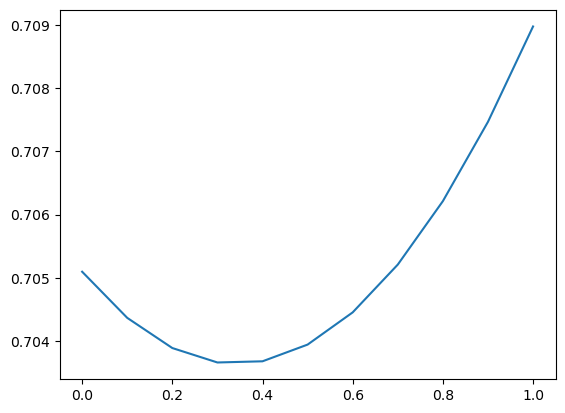

In [27]:
sns.lineplot(y=b_score_list, x=p_weight_list)

In [28]:
p_weight_list_2 = [0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37]
b_score_list_2 = test_p_weight(p_weight_list_2, matchup_pairs_full, T_batters_dict_1518_new, T_pitchers_dict_1518_new)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

  0%|          | 0/31448 [00:00<?, ?it/s]

In [29]:
list(zip(p_weight_list_2, b_score_list_2))

[(0.27, 0.7037075897899283),
 (0.28, 0.7036909821138065),
 (0.29, 0.7036768425852262),
 (0.3, 0.7036651693156838),
 (0.31, 0.7036559605167703),
 (0.32, 0.7036492145000567),
 (0.33, 0.7036449296769832),
 (0.34, 0.703643104558753),
 (0.35, 0.7036437377562312),
 (0.36, 0.7036468279798469),
 (0.37, 0.7036523740394993)]

In [32]:
np.array(b_score_list_2).min()

0.703643104558753

<AxesSubplot:>

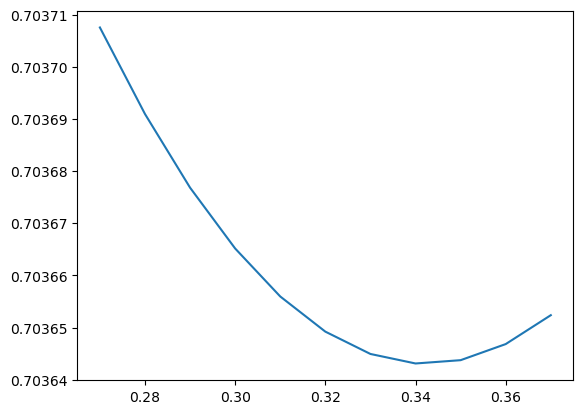

In [33]:
sns.lineplot(y=b_score_list_2, x=p_weight_list_2)

### Best p_weight = 0.34

# Predict P using best weight

In [42]:
P_matchup_dict = {}
for pair in tqdm(matchup_pairs_list):
    P_matchup_dict[pair] = main.sim_steady_state_matchUp(pair[0], pair[1], p_weight=0.34, _return_df=False, batter_dict=T_batters_dict_1518_new, pitcher_dict=T_pitchers_dict_1518_new)

P_predicted = np.array([P_matchup_dict[pair] for pair in matchup_pairs_full])

  0%|          | 0/31448 [00:00<?, ?it/s]

NameError: name 'T_batters_dict_1518_new' is not defined

In [39]:
P_predicted = normalize_P(P_predicted)

In [42]:
P_predicted_df = pd.DataFrame(P_predicted, columns=main.PROBA_LIST)
P_predicted_df.head()

,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba
0,0.15233,0.04098,0.00338,0.03334,0.43525,0.11523,0.21681,0.00269
1,0.14255,0.04247,0.00706,0.03926,0.48365,0.06675,0.21571,0.00255
2,0.17078,0.05048,0.00624,0.02255,0.51881,0.07257,0.15697,0.00160
3,0.10098,0.03763,0.00461,0.05643,0.37191,0.11328,0.31327,0.00189
4,0.15671,0.05101,0.00390,0.03310,0.48403,0.07751,0.19030,0.00345


In [43]:
pa_df = pd.concat([pa_df, P_predicted_df], axis=1)

In [58]:
# pa_df.to_csv('data/PA_data_19_012023.csv')

In [45]:
pa_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,stand,p_throws,event_type,des,1B,2B,3B,HR,FO,BB,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba
0,2019,564734,1,518774,425783,LAA,L,R,BB,Shin-Soo Choo hit by pitch.,0,0,0,0,0,1,0,0,0.15233,0.04098,0.00338,0.03334,0.43525,0.11523,0.21681,0.00269
1,2019,564734,2,518774,596059,LAA,L,R,K,Rougned Odor strikes out swinging.,0,0,0,0,0,0,1,0,0.14255,0.04247,0.00706,0.03926,0.48365,0.06675,0.21571,0.00255
2,2019,564734,3,518774,462101,LAA,R,R,1B,Elvis Andrus singles on a line drive to right ...,1,0,0,0,0,0,0,0,0.17078,0.05048,0.00624,0.02255,0.51881,0.07257,0.15697,0.00160
3,2019,564734,4,518774,608336,LAA,L,R,HR,Joey Gallo homers (2) on a fly ball to center ...,0,0,0,1,0,0,0,0,0.10098,0.03763,0.00461,0.05643,0.37191,0.11328,0.31327,0.00189
4,2019,564734,5,518774,452678,LAA,L,R,BB,Asdrubal Cabrera walks.,0,0,0,0,0,1,0,0,0.15671,0.05101,0.00390,0.03310,0.48403,0.07751,0.19030,0.00345


In [46]:
sum_actual_df = pa_df[main.EVENT_LIST].sum().rename_axis('events').reset_index(name='count_actual')

In [47]:
sum_pred_df = pa_df[main.PROBA_LIST].sum().rename_axis('events_2').reset_index(name='count_pred')

In [48]:
sum_all_df = pd.concat([sum_actual_df, sum_pred_df], axis=1)
sum_all_df.drop(columns='events_2', inplace=True)

In [49]:
sum_all_df['error_pct'] = (sum_all_df['count_actual'] - sum_all_df['count_pred'])/sum_all_df['count_actual']

In [50]:
sum_all_df

,events,count_actual,count_pred,error_pct
0,1B,11810,12484.61327,-0.05712
1,2B,3920,3869.04310,0.01300
2,3B,349,417.13177,-0.19522
3,HR,3149,2633.29953,0.16377
4,FO,38240,38725.51532,-0.01270
5,BB,7622,7529.57748,0.01213
6,K,18374,17806.33149,0.03090
7,other,197,195.48803,0.00767


In [51]:
sum_all_df['count_actual'].sum()

83661

In [52]:
sum_all_df['count_pred'].sum()

83661.0

### Brier Score:

In [ ]:
# without year weight
main.get_brier_score(pa_df[main.EVENT_LIST].values, P_predicted_df[main.PROBA_LIST].values)

In [ ]:
# with year weight
main.get_brier_score(pa_df[main.EVENT_LIST].values, P_predicted_df_jan18[main.PROBA_LIST].values)

### Baseline Brier Score: 0.7036459613287046

# Get league average P

In [28]:
pa_df_1518 = data_test_df[(data_test_df['pitcher'].isin(pitcher_quali_list)&(data_test_df['batter'].isin(batter_quali_list)))]\
            .groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter']).\
            agg({'event_type':'first'}).reset_index()
pa_df_1518.head()

,game_year,game_pk,at_bat_number,pitcher,batter,event_type
0,2019,564734,1,518774,425783,BB
1,2019,564734,2,518774,596059,K
2,2019,564734,3,518774,462101,1B
3,2019,564734,4,518774,608336,HR
4,2019,564734,5,518774,452678,BB


In [29]:
P_league_avg_df = pa_df_1518['event_type'].value_counts(normalize=True).rename_axis('events').reset_index(name='proba')
P_league_avg_df

,events,proba
0,FO,0.45708
1,K,0.21962
2,1B,0.14116
3,BB,0.09111
4,2B,0.04686
5,HR,0.03764
6,3B,0.00417
7,other,0.00235


In [30]:
P_league_avg_arr = np.array([])
for e in main.EVENT_LIST:
    P_league_avg_arr = np.append(P_league_avg_arr, P_league_avg_df[P_league_avg_df['events']==e]['proba'])

## Test accuracy using league average

In [43]:
P_predicted_league = np.tile(P_league_avg_arr, [len(pa_df), 1])
main.get_brier_score(pa_df[main.EVENT_LIST].values, P_predicted_league)

0.710977484903155

## Test accuracy using random proba

In [44]:
P_rand = np.random.dirichlet(np.ones(8), size=len(pa_df))
main.get_brier_score(pa_df[main.EVENT_LIST].values, P_rand)

0.9739460742925328